# Assignment 4: Passive Network Measurement

Network operators look at different types of network traffic data to understand properties of their networks. Some network data can be collected directly from network devices (e.g., routers, switches) while they are forwarding live traffic.  Collecting this data does not affect network behavior and is therefore called "passive" (as opposed to "active" measurements).

In this assignment, you will analyze two types of passive network measurement data---traffic volumes and BGP routes.

This notebook has several parts. Each part contains sections marked with TODO that you need to complete. 

**You should work with a partner on this assignment. Put your names and netIDs in the cell below:**

**Names:** Yang Song, Zhuo Qun Song

**NetIds:** yangsong, zsong

## Background

### Traffic Measurement with IPFIX

Routers in most networks collect traffic measurements using the [IPFIX protocol](https://en.wikipedia.org/wiki/IP_Flow_Information_Export). [NetFlow](https://en.wikipedia.org/wiki/NetFlow), a proprietary form of IPFIX defined by Cisco, is well-known in the networks community because Cisco supplies routers for many large networks.

In this part of the assignment, you'll analyze a trace of NetFlow records captured from a router that connects the Princeton campus network to the Internet. The assignment will ask you to perform similar kinds of analysis that a network operator would perform -- asking questions about the most popular endpoints for traffic on the Princeton campus, the most popular web applications, and so forth. (As you can imagine, when we start to think about security, the ability to analyze these baselines will come in handy!)

The flow records are in the file 'netflow.csv' in the `assignment4` folder.  To simplify the analysis, we have ensured that the IP addresses of the Princeton campus network start with 128.112 and have their 16 lower bits anonymized to protect the privacy of users on the campus network (i.e., all of us!). To further simplify your task, we have parsed these records into CSV (comma-separated variable) format, with the names of the fields listed in the first row of the file. (In a real network, routers export IPFIX records as binary files.)

### Measurement of Interdomain Routing with BGP Routing Tables

To help network operators understand the state of Internet routing, many routers have the ability to "dump" BGP routing tables periodically into a static file. These routing tables contain information about each IP prefix, all BGP routes that the router learns for each prefix, and the "best" BGP route that the router ultimately selects. Analyzing the BGP routing tables can provide information about where traffic to different IP prefixes is destined.

In this assignment, we have provided you a routing table dump from a project called RouteViews (http://www.routeviews.org/). You can visit that site to learn more about the routing tables that they collect. `telnet route-views2.routeviews.org` will also give you a command-line prompt at a real BGP router at the routeviews project if you want to play around with a live routing table view.  http://routeviews.org/bgpdata/ has periodic binary routing table dumps and update logs from participating routers. Again, for this assignment, we have parsed the binary routing table dumps into a format that is easier to analyze directly. The data is located in the `bgp_rib.csv` file in the `assignment4` directory.

### Functional data analysis with map() and reduce()

Several of the data analysis steps in this assignment use a "MapReduce" programming model. MapReduce originated in functional programming languages and involves using two functions (called `map()` and `reduce()`...surprise!) to apply functions to iterable data (like linked-lists, arrays, etc.). 

##### map()

A general `map()` function has two arguments: another function (which itself takes one argument) and an iterable object. `map()` then applies (maps) the argument function to every item in the iterable object. See the documentation of Python's built-in `map()`function for more details: https://docs.python.org/2/library/functions.html#map. The following toy example uses `map()` to add 3 to every element of a list

In [2]:
some_numbers = [1,2,3]
three_more = map(lambda x: x+3, some_numbers)
print three_more

[4, 5, 6]


`map()` is often used with anonymous function (the `lambda` in the above example), but can be used just as easily with normal functions:

In [3]:
def add3(i):
    return i+3
 
some_numbers = [1,2,3]
three_more = map(add3, some_numbers)
print three_more

[4, 5, 6]


Note that real implementations of `map()` allow the mapped function to take more than one argument or include more information in a closure, but this won't be necessary for this assignment.

##### reduce()

A general `reduce()` function takes another function (which itself takes *two* values), an iterable object, and an optional initializer value.  The argument function is applied to the first two elements in the iterable object (or the first element and the initializer value) to get a return value. The function is then applied to this return value and the next item in the iterable object. This continues through the iterable object until only a single return value remains. This allows `reduce()` to compute summaries over all data in the iterable object. See the documentation of Python's built-in `reduce()` function for more details: https://docs.python.org/2/library/functions.html#reduce. The following example uses `reduce()` to count the number of 4s in a list of integers:

In [4]:
def count_4s(count, i):
    # The order of the arguments matters. 
    #     The first argument is the accumulated value
    #     The secod argument is next value from the iterable
    if i == 4:
        return count + 1
    else:
        return count

some_numbers = [1,4,0,1,4]
num_fours = reduce(count_4s, some_numbers, 0) # 0 is the initializer value 
print num_fours

2


Again, real implementations of `reduce()` allow the reduction function to take more than two arguments or include more information in a closure, but this won't be necessary for this assignment.

MapReduce programming is popular because it allows analysis tasks on large data sets to be easily parallelized (https://en.wikipedia.org/wiki/MapReduce).  Although there are many open-source and proprietary MapReduce-style data processing libraries (typically with different ways of expressing iterable datasets and distributing tasks over many computers), they all involve `map()` and `reduce()` functions like you will use in this assignment.  If you are interested in learning more about functional programming for data analysis, you should take COS 326.

## Part A: IPFIX Data

### Parse IPFIX Data
The `netflow.csv` file contains pre-processed netflow data from a Princeton campus network border router. The data is "unsampled," i.e. it compiles flow statistics for every packet that traverses any interface on the border router.  We used the `nfdump` tool to process the raw NetFlow data that the router collected. Each row of the `netflow.csv` file, except for the header on top, logs the following information for a flow:

```
Date first seen, Time first seen (m:s), Date last seen, Time last seen (m:s), Duration (s), Protocol, 
Src IP addr, Src port, Dst IP addr, Dst port, Packets, Bytes, Flags, Input interface, Output interface		

```

To analyze this data, we first need to read it into a python data structure.  The following code uses the built-in `csv` library to read `netflow.csv` into a list of dictionaries.  The `csv` library documentation is here if you are interested: https://docs.python.org/2/library/csv.html


In [5]:
import csv

with open('netflow.csv', 'r') as netflow_file:
    netflow_reader = csv.DictReader(netflow_file)
    netflow_data = list(netflow_reader)
    
print "Number of flow records: {}".format(len(netflow_data))
print
print "Sample flow record: {}".format(netflow_data[0])

Number of flow records: 105360

Sample flow record: {'Dst IP addr': '128.112.213.189', 'Protocol': 'ICMP', 'Bytes': '94', 'Src port': '0', 'Src IP addr': '172.16.241.1', 'Input interface': '120', 'Packets': '1', 'Date first seen': '10/29/15', 'Output interface': '0', 'Duration (s)': '0', 'Time first seen (m:s)': '04:48.9', 'Flags': '.A....', 'Time last seen (m:s)': '04:48.9', 'Dst port': '11', 'Date last seen': '10/29/15'}


### Analyze IPFIX Data

The following sections each focus on answering a specific question using the netflow data you have prepared. These questions are both of interest to real network operators and might reveal some surprising facts about how we (as a Princeton community) use the Internet.  

#### What are the most popular IP addresses accessed by users of the Princeton network?

In order to answer this question, we have to decide how to measure IP address popularity. Total traffic volume across all flows seems like a reasonable option, but so does total number of flows to an IP address regardless of volume.  Network operaters actually use both metrics (among others), which we will do here as well.  

*Step 1: Determine popular IP addresses by number of flows*

Complete the following code to produce a python dictionary `ips_by_flows` with counts of the total number of flows to each external (not 128.112.\*.\*) IP address in `netflow_data`.  The keys of the dict should be IP addresses and the values should be integer flow counts.

First complete the `count_by_flows()` function, which should take an existing dict of the form described above and update it appropriately from `current_flow`.  If you are confused about datatypes, use print statements to inspect variables. 

You may want to create an additional helper function to test if an IP address starts with 128.112. Helpful string methods are documented here: https://docs.python.org/2/library/stdtypes.html#string-methods.

You will then need to use the `reduce()` function to build a dictionary result.  As a hint, the initializer argument to `reduce()` should be `defaultdict(lambda: 0)`. The [defaultdict()](https://docs.python.org/2/library/collections.html#collections.defaultdict)  function creates a dictionary with default values that are the output of the argument function (in this case, just 0). This allows you to increment the value of a particular key without first checking to see if the key is already in the dictionary (if you used `{}` to create the dict instead of `defaultdict()`, this would raise a KeyError).

The provided code will print and plot the most popular IPs.  The `check_ips_by_flows()` function will compare the md5 hash of the top 15 most popular IPs your answer against the md5 hash of the correct answer. This will print a message letting you know whether you are correct or need to keep debugging. 

Most popular IP addresses by number of flows: [('116.211.0.90', 17015), ('169.54.233.126', 9424), ('163.53.247.3', 2981), ('169.45.161.189', 2494), ('222.186.190.71', 2413)]

Hashes match. Your ips_by_flows is correct.


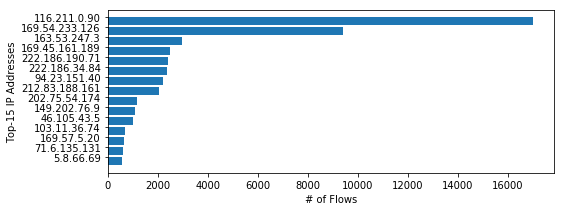

In [6]:
%matplotlib inline
from collections import defaultdict
from plotting import plot_flows
from testing import check_ips_by_flows

# TODO: complete count_by_flows function
def count_by_flows(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    dest = current_flow['Dst IP addr']
    if not dest.startswith('128.112.'):
        counts[dest] += 1
    src = current_flow['Src IP addr']
    if not src.startswith('128.112.'):
        counts[src] += 1
    return counts    

# TODO: use reduce() function to apply count_by_flows to netflow_data and assign the result to ips_by_flows
ips_by_flows = reduce(count_by_flows, netflow_data, defaultdict(lambda: 0))

# print the top 5 IP addresses by number of flows 
sorted_ips_by_flows = sorted(ips_by_flows.items(), reverse=True, key=lambda x: x[1])
print "Most popular IP addresses by number of flows: {}\n".format(sorted_ips_by_flows[0:5])

# check the results
check_ips_by_flows(sorted_ips_by_flows[0:15])

# plot the results
plot_flows(sorted_ips_by_flows)

*Step 2: Determine popular IP addresses by total volume*

Complete the following code to produce a dict `ips_by_volume` with counts of the total number of bytes to each external (non-Princeton) IP address.  The keys of the dict should be IP addresses and the values should be integer byte counts. Remember that the values in `netflow_data` are strings. You will need to convert them to ints or floats to do arithmetic.

Most popular IP addresses by volume: [('212.83.188.161', 928311), ('169.54.233.126', 867928), ('116.211.0.90', 680600), ('169.45.161.189', 229448), ('42.120.221.22', 191958)]

Hashes match. Your ips_by_volume is correct.


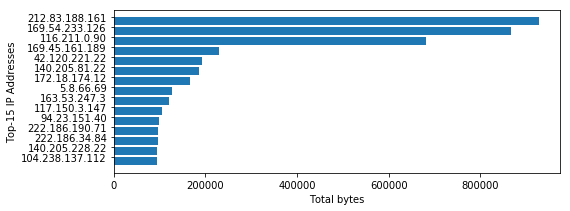

In [7]:
%matplotlib inline
from plotting import plot_volumes
from testing import check_ips_by_volume

# TODO: complete count_by_volume function
def count_by_volume(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    dest = current_flow['Dst IP addr']
    if not dest.startswith('128.112.'):
        counts[dest] += int(current_flow['Bytes'])
    src = current_flow['Src IP addr']
    if not src.startswith('128.112.'):
        counts[src] += int(current_flow['Bytes'])
    return counts
        
# TODO: use reduce() function to apply count_by_volume to netflow_data and assign the result to ips_by_volume
ips_by_volume = reduce(count_by_volume, netflow_data, defaultdict(lambda: 0))

# print the top 5 IP addresses by volume
sorted_ips_by_volume = sorted(ips_by_volume.items(), reverse=True, key=lambda x: x[1])
print "Most popular IP addresses by volume: {}\n".format(sorted_ips_by_volume[0:5])

# check the results
check_ips_by_volume(sorted_ips_by_volume[0:15])

# plot the results
plot_volumes(sorted_ips_by_volume)

#### What are the most popular applications (by protocol) for Princeton network users?

What application protocols do you think are the most common on the Princeton network?  Web traffic (HTTP & SSL)? Secure remote connection (SSH)? Email (SMTP, IMAP, POP3)?  In practice, a network operator may want to identify popular applications  to make provisioning plans or change network configurations to treat traffic from different applications differently (e.g., to route traffic on different links). This could prevent high-volume applications, (e.g. video streaming) from interrupting the performance of critical low-volume applications.  

You can answer these questions by finding the most popular ports of traffic flows in the netflow data. Many application protocols use well-known fixed ports for their traffic.  For example, HTTP traffic happens on port 80, SSL traffic on port 443, SSH traffic on port 22, SMTP on port 25. 

Again we will use both number of flows and total traffic volume as metrics for port "popularity".

Complete the following code to create `ports_by_flows` and `ports_by_volume` dicts from the netflow data.  Use the same strategy as you did above to create `ips_by_flows` and `ips_by_volume`. 

Include all destination ports and source ports **lower than 1024** (ports lower than 1024 are "well-known" and easily mapped to applications). 

Most popular ports by number of flows: [('23', 19546), ('53', 6480), ('80', 6352), ('443', 5788), ('0', 4712)]
Most popular ports by volume: [('23', 2324852), ('53', 1437375), ('161', 752840), ('0', 509011), ('80', 309148)]

Hashes match. Your ports_by_flows is correct.
Hashes match. Your ports_by_volume is correct.


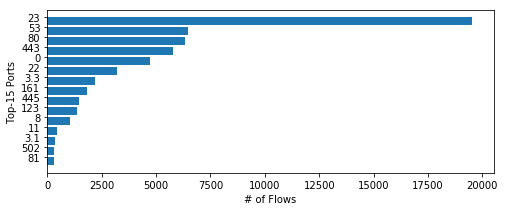

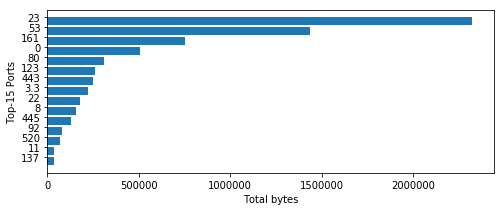

In [8]:
%matplotlib inline
from plotting import plot_ports
from testing import check_ports_by_flows, check_ports_by_volume

# TODO: create ports_by_flows and ports_by_volume dicts from netflow_data
def count_ports_by_flows(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    dest = current_flow['Dst port']
    try:
        if int(dest) < 1024:
            counts[dest] += 1
    except:
        if dest.startswith('3.'):
            counts[dest] += 1
    src = current_flow['Src port']
    try:
        if int(src) < 1024:
            counts[src] += 1
    except:
        if dest.startswith('3.'):
            counts[src] += 1
    return counts

def count_ports_by_volume(counts, current_flow):
    # counts is the current dict result
    # current_flow being processed
    dest = current_flow['Dst port']
    try:
        if int(dest) < 1024:
            counts[dest] += int(current_flow['Bytes'])
    except:
        if dest.startswith('3.'):
            counts[dest] += int(current_flow['Bytes'])
    src = current_flow['Src port']
    try:
        if int(src) < 1024:
            counts[src] += int(current_flow['Bytes'])
    except:
        if dest.startswith('3.'):
            counts[src] += int(current_flow['Bytes'])
    return counts

ports_by_flows = reduce(count_ports_by_flows, netflow_data, defaultdict(lambda: 0))
ports_by_volume = reduce(count_ports_by_volume, netflow_data, defaultdict(lambda: 0))


# Print the most popular ports and check the results
sorted_ports_by_flows = sorted(ports_by_flows.items(), reverse=True, key=lambda x: x[1])
sorted_ports_by_volume = sorted(ports_by_volume.items(), reverse=True, key=lambda x: x[1])
print "Most popular ports by number of flows: {}".format(sorted_ports_by_flows[0:5])
print "Most popular ports by volume: {}\n".format(sorted_ports_by_volume[0:5])
check_ports_by_flows(sorted_ports_by_flows[0:15])
check_ports_by_volume(sorted_ports_by_volume[0:15])

# plot the results 
plot_ports(sorted_ports_by_flows, sorted_ports_by_volume)

### Questions

Answer the following questions about the results of the above analysis. 

#### Q1. 
What are the 5 most popular external (non-Princeton) IP addresses by number of flows and by traffic volume?

#### A1.

Most popular IP addresses by number of flows: `[('116.211.0.90', 17015), ('169.54.233.126', 9424), ('163.53.247.3', 2981), ('169.45.161.189', 2494), ('222.186.190.71', 2413)]`

| External IP address | Flows   |
|------|------|
|   116.211.0.90  | 17015|
|   169.54.233.126  | 9424|
|   163.53.247.3  | 2981|
|   169.45.161.189  | 2494|
|   222.186.190.71  | 2413|


Most popular IP addresses by volume: `[('212.83.188.161', 928311), ('169.54.233.126', 867928), ('116.211.0.90', 680600), ('169.45.161.189', 229448), ('42.120.221.22', 191958)]`

| External IP address | Volume   |
|------|------|
|   212.83.188.161  | 928311|
|   169.54.233.126  | 867928|
|   116.211.0.90  | 680600|
|   169.45.161.189  | 229448|
|   42.120.221.22  | 191958|

#### Q2. 
Use the "whois" command from your Vagrant terminal to learn what you can about these IP addresses (e.g. `whois 169.54.233.126`).  Choose 2 addresses from your answer to Q1 and write up what you learned, as well as why you think they were among the most popular. 

#### A2. 
whois 116.211.0.90
Chinanet Hubei Province Network

whois 169.53.247.3
SoftLayer Technologies, Inc.

whois 169.45.161.189
SoftLayer - Console

whois 222.186.190.71
Chinanet Jiangsu

whois 169.54.233.126
Net Systems Research LLC

---

Chinanet networks host a large proportion (65% of domain names and 70% of traffic by volume) of Chinese internet content. SoftLayer is a server and cloud computing provider. It makes sense that these are among the most popular IP addresses by volume and flows because they provide many different services. Net Systems LLC is a network monitor (presumably the one that Princeton uses), and so each user would contribute flows to Net Systems LLC. 

#### Q3. 
What are the 5 most popular ports by number of flows and by traffic volume? What applications are associated them? There is a wikipedia page of fixed ports here: https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers. You can also search online to find fixed port/application mappings.  Are you suprised by which applications are the most popular?

#### A3.

Most popular ports by number of flows: `[('23', 19546), ('53', 6480), ('80', 6352), ('443', 5788), ('0', 4712)]`

| Port | Flows   | Application |
|------|------|------|
|   23  | 928311| Telnet protocol—unencrypted text communications |
|   53  | 867928| Domain Name System (DNS) | 
|   80  | 680600| Hypertext Transfer Protocol (HTTP) |
|   443  | 229448| Hypertext Transfer Protocol over TLS/SSL (HTTPS) |
|   0  | 191958| Reserved Port that tells system to find a suitable port number |


Most popular ports by volume: `[('23', 2324852), ('53', 1437375), ('161', 752840), ('0', 509011), ('80', 309148)]`

| Port | Volume   | Application |
|------|------|------|
|   23  | 2324852| Telnet protocol—unencrypted text communications |
|   53  | 1437375| Domain Name System (DNS) | 
|   161  | 752840| Simple Network Management Protocol (SNMP) |
|   0  | 509011| Reserved Port that tells system to find a suitable port number |
|   80  | 309148| Hypertext Transfer Protocol (HTTP) |

Yes, we expected that most of the contribution would be from http. We thought that DNS would not have as many flows because we would often go to the same websites, whose addresses would be cached. We were surprised that telnet was the most popular for both.

#### Q4. 
Why do you think that telnet (port 23) composes so much of the traffic through Princeton's network?

#### A4. 
Telnet may be used whenever accessing a Princeton service that requests data from other Princeton services, which may use telnet because encryption is not necessary. 

#### Q5. 
The provided NetFlow data was captured over a 5 minute period from approximately 6:05am to 6:10am. How much do you think the capture time affected the resulting most popular applications?  What changes would you expect to see if the data had been captured during a different 5 minute window (of your choice)? 

#### A5.
There is probably not a lot of user activity during this time at Princeton, so much of the contribution could be activity from other countries. Thus, there would be fewer consumer application volume compared to later. We would thus probably expect more HTTP and HTTPS requests. We would probably expect less traffic to and from China, and perhaps more from North American data providers. The time would probably not affect telnet as much if most of the telnet volume was not user-initiated.

## Part B: Analyze BGP Routing Tables

Up until this point in the assignment, we have looked at top traffic flows at the level of IP addresses and ports, but a network operator might also be interested in exploring which other networks (i.e., autonomous systems) are responsible for sending or receiving traffic to the network. From our previous lectures on peering and Internet business relationships, it should be clear why an operator might care about knowing which ASes are sending traffic its way! This information may also be useful for exploring various kinds of network attacks (e.g., sources of denial of service attacks), which we will explore in the next assignment.

The RouteViews project allows network operators to obtain real-time information about the global routing system from the perspectives of several different autonomous systems around the Internet. RouteViews servers act as software BGP routers, obtaining their BGP routing information via BGP sessions, just like any other router would learn BGP routes. The main difference between the RouteViews servers and other BGP-speaking routers is that the RouteViews servers do not forward any real Internet traffic.

RouteViews periodically logs BGP routing tables (sometimes called a Routing Information Base, or a "RIB") in a binary format called MRT. We collected data from one such server and used the `bgpdump` tool to parse the data into a more parsable output format. The entries in the BGP RIB table look like the ones shown below: 
```
TIME: 03/07/16 02:00:00
TYPE: TABLE_DUMP_V2/IPV4_UNICAST
PREFIX: 0.0.0.0/0
SEQUENCE: 0
FROM: 185.44.116.1 AS47872
ORIGINATED: 03/06/16 20:27:05
ORIGIN: IGP
ASPATH: 47872 3356
NEXT_HOP: 185.44.116.1
COMMUNITY: 3356:2 3356:514 3356:2087 47872:1 47872:3356

TIME: 03/07/16 02:00:00
TYPE: TABLE_DUMP_V2/IPV4_UNICAST
PREFIX: 0.0.0.0/0
SEQUENCE: 0
FROM: 80.241.176.31 AS20771
ORIGINATED: 03/04/16 10:21:21
ORIGIN: IGP
ASPATH: 20771 1299
NEXT_HOP: 80.241.176.31
```

BGP RIBs might have multiple entries for an IP prefix. 

For this assignment, we considered only a single entry for an IP prefix. We translated this data into the `bgp_rib.csv` file. Each contains the following fields:
```
TIME, ORIGIN, FROM, SEQUENCE, ASPATH, PREFIX, NEXT_HOP
```

The following code imports the `bgp_rib.csv` file into a list of dicts (like we did for `netflow_data` above).

In [9]:
import csv

with open('bgp_rib.csv', 'r') as bgp_file:
    bgp_reader = csv.DictReader(bgp_file,delimiter=";")
    bgp_data = list(bgp_reader)
    
print "Number of BGP RIBs: {}".format(len(bgp_data))
print
print "Sample BGP RIB: {}".format(bgp_data[0])

Number of BGP RIBs: 208272

Sample BGP RIB: {'ORIGIN': 'IGP', 'FROM': '80.249.208.200 AS12859', 'SEQUENCE': '0', 'ASPATH': '12859 3257 4637 1221 38803 56203', 'PREFIX': '1.0.4.0/24', 'NEXT_HOP': '80.249.208.200', 'TIME': '03/07/16 00:00:00'}


#### What is the longest route (by number of unique ASes) in the BGP RouteViews data?

To answer this question, you will need to sort `bgp_data` by the number of **unique** AS numbers in the "ASPATH" field.  

Complete the code below to find the longest ASPATH and assign it to the `longest_aspath` variable.  You can use Python's built-in `sorted()` function (https://docs.python.org/2/library/functions.html#sorted) or another method of your choosing.

In [10]:
from testing import check_longest_aspath

# TODO: Find the longest (by number of *unique* AS numbers) ASPATH and assign it to the 'longest_aspath' variable
longest_aspath = sorted(map(lambda x: (len(set(x['ASPATH'].split())), x['ASPATH']), bgp_data), key=lambda x:-x[0])[0][1]

# print and check the longest ASPATH
print "The longest ASPATH is: {}\n".format(longest_aspath)
check_longest_aspath(longest_aspath)

The longest ASPATH is: 20562 9002 9198 12997 51346 24722 8449 3356 38193 55330 131284 131284 131284 131284 131284 131284 131284 131284 131284 131284 58630

Hashes match. Your longest_aspath is correct.


### Questions

#### Q6.
If you search online for "AS number lookup" you will find several AS search services. Look up the ASes in this longest route to find their countries of origin. List these countries in order.

#### A6. 

| AS | Country of Origin   |
|------|------|
|   20562  | Netherlands|
|   9002  | European Union|
|   9198  | Kazakhstan|
|   12997  | Kyrgyzstan|
|   51346  | Russia|
|   24722  | Russia|
|   8449  | Kyrgyzstan|
|   3356  | Venezuela|
|   38193  | Pakistan|
|   55330  | Afghanistan|
|   131284  | Afghanistan|
|   58630  | Afghanistan|

#### Q7. 
Why might such long BGP routes be a concern for network operators? Give at least 2 reasons.

#### A7.
Long BGP routes that go through a lot of countries has more security vulnerabilities, because of more sources of data tampering. Also, long BGP routes are more latent. Long AS's may also be a concern because they may also indicate poor interdomain routing algorithms by the AS's. For example, in the longest path, the AS 131284 redirected to itself 9 times. 

## Submission

**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**

Submit this file (Assignment4_Notebook.ipynb) on CS Dropbox here: https://dropbox.cs.princeton.edu/COS461_S2017/Assignment_4_-_Passive_Network_Measurement. Submit only once for both partners. Remember to put your names and netids in the marked location at the top of this file. 